In [1]:
# HIDDEN
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import math
import numpy as np
from scipy import stats

In [2]:
# HIDDEN

colors = Table.read_table('roulette_wheel.csv').column('Color')
pockets = make_array('0','00')
for i in np.arange(1, 37):
    pockets = np.append(pockets, str(i)) 

wheel = Table().with_columns(
    'Pocket', pockets,
    'Color', colors
)

### The Central Limit Theorem ###
Very few of the data histograms that we have seen in this course have been bell shaped. When we have come across a bell shaped distribution, it has almost invariably been an empirical histogram of a statistic based on a random sample.

The examples below show two very different situations in which an approximate bell shape appears in such histograms.

### Net Gain in Roulette ###
In an earlier section, the bell appeared as the rough shape of the total amount of money we would make if we placed the same bet repeatedly on different spins of a roulette wheel. 

In [16]:
wheel

Pocket,Color
0,green
00,green
1,red
2,black
3,red
4,black
5,red
6,black
7,red
8,black


Recall that the bet on red pays even money, 1 to 1. We defined the function `red_winnings` that returns the net winnings on one \$1 bet on red. Specifically, the function takes a color as its argument and returns 1 if the color is red. For all other colors it returns -1.

In [18]:
def red_winnings(color):
    if color == 'red':
        return 1
    else:
        return -1

The table `red` shows each pocket's winnings on red.

In [19]:
red = wheel.with_column(
    'Winnings: Red', wheel.apply(red_winnings, 'Color')
    )
red

Pocket,Color,Winnings: Red
0,green,-1
00,green,-1
1,red,1
2,black,-1
3,red,1
4,black,-1
5,red,1
6,black,-1
7,red,1
8,black,-1


Your net gain on one bet is one random draw from the `Winnings: Red` column. There is an 18/38 chance making \$1, and a 20/38 chance of making -$1. This probability distribution is shown in the histogram below.

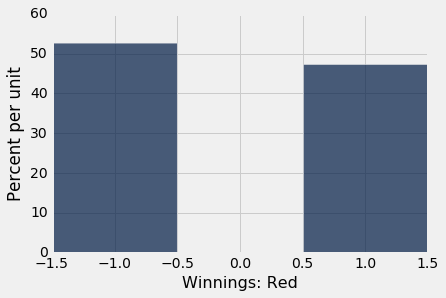

In [36]:
red.select('Winnings: Red').hist(bins=np.arange(-1.5, 1.6, 1))

Now suppose you bet many times on red. Your net winnings will be the sum of many draws made at random with replacement from the distribution above.

It will take a bit of math to list all the possible values of your net winnings along with all of their chances. We won't do that; instead, we will approximate the probability distribution by simulation, as we have done all along in this course. 

The code below simulates your net gain if you bet \$1 on red on 400 different spins of the roulette wheel. 

In [48]:
num_bets = 400
repetitions = 10000

net_gain_red = make_array()

for i in np.arange(repetitions):
    spins = red.sample(num_bets)
    new_net_gain_red = spins.column('Winnings: Red').sum()
    net_gain_red = np.append(net_gain_red, new_net_gain_red)


results = Table().with_column(
    'Net Gain on Red', net_gain_red
    )

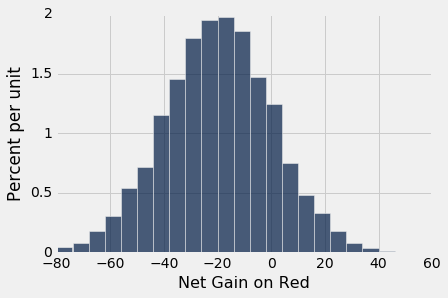

In [49]:
results.hist(bins=np.arange(-80, 50, 6))

That's a roughly bell shaped histogram, even though the distribution we are drawing from is nowhere near bell shaped.

**Center.** The distribution is centered near -\$20, roughly. To see why, note that your winnings will be \$1 on about 18/38 of the bets, and -\$1 on the remaining 20/38. So your average winnings per dollar bet will be roughly -5.26 cents:

In [44]:
average_per_bet = 1*(18/38) + (-1)*(20/38)
average_per_bet

-0.05263157894736842

So in 400 bets you expect that your net gain will be about -\$21:

In [45]:
400 * average_per_bet

-21.052631578947366

For confirmation, we can compute the mean of the 10,000 simulated net gains:

In [50]:
np.mean(results.column(0))

-20.852799999999998

**Spread.** Run your eye along the curve starting at the center and notice that the point of inflection is near 0. On a bell shaped curve, the SD is the distance from the center to a point of inflection. The center is roughly -\$20, which means that the SD of the distribution is around \$20.

In the next section we will see where the \$20 comes from. For now, let's confirm our observation by simply calculating the SD of the 10,000 simulated net gains:

In [51]:
np.std(results.column(0))

20.201463614302803

**Summary.** The net gain in 400 bets is the sum of the 400 amounts won on each individual bet. The probability distribution of that sum is approximately normal, with an average and an SD that we can approximate.

### Average Flight Delay ###
The table `united` contains data on departure delays of 13,825 United Airlines domestic flights out of San Francisco airport in the summer of 2015. As we have seen before, the distribution of delays has a long right-hand tail.

In [53]:
united = Table.read_table('united_summer2015.csv')

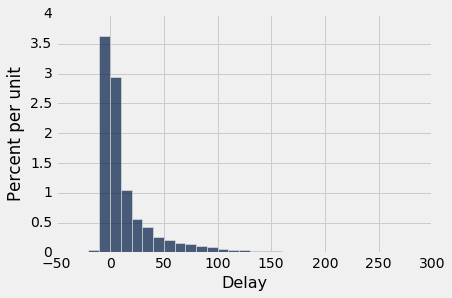

In [54]:
united.select('Delay').hist(bins=np.arange(-20, 300, 10))

The mean delay was about 16.6 minutes and the SD was about 39.5 minutes. Notice how large the SD is, compared to the mean. Those large deviations on the right have an effect, even though they are a very small proportion of the data.

In [57]:
mean_delay = np.mean(united.column('Delay'))
sd_delay = np.std(united.column('Delay'))

mean_delay, sd_delay

(16.658155515370705, 39.480199851609314)

Now suppose we sampled 400 delays at random with replacement. You could sample without replacement if you like, but the results would be very similar to with-replacement sampling. If you sample a few hundred out of 13,825 without replacement, you hardly change the population each time you pull out a value.

In the sample, what could the average delay be? We expect it to be around 16 or 17, because that's the population average; but it is likely to be somewhat off. Let's see what we get by sampling. We'll work with the table `delay` that only contains the column of delays.

In [59]:
delay = united.select('Delay')

In [61]:
np.mean(delay.sample(400).column('Delay'))

15.192500000000001

The sample average varies according to how the sample comes out, so we will simulate the sampling process repeatedly and draw the empirical histogram of the sample average. That will be an approximation to the probability histogram of the sample average.

In [76]:
sample_size = 400
repetitions = 10000

means = make_array()

for i in np.arange(repetitions):
    sample = delay.sample(sample_size)
    new_mean = np.mean(sample.column('Delay'))
    means = np.append(means, new_mean)

results = Table().with_column(
    'Sample Mean', means
)

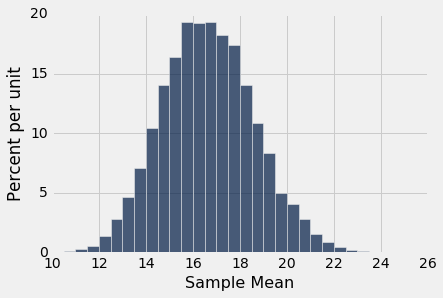

In [77]:
results.hist(bins=np.arange(10, 25, 0.5))

Once again, we see a rough bell shape, even though we are drawing from a very skewed distribution. The bell is centered somewhere between 16 ad 17, as we expect.

### Central Limit Theorem ###

The reason why the bell shape appears in such settings is a remarkable result of probability theory called the **Central Limit Theorem**. 

**The Central Limit Theorem says that the probability distribution of the sum or average of a large random sample drawn with replacement will be roughly normal, *regardless of the distribution of the population from which the sample is drawn*.**

As we noted when we were studying Chebychev's bounds, results that can be applied to random samples *regardless of the distribution of the population* are very powerful, because in data science we rarely know the distribution of the population.

The Central Limit Theorem makes it possible to make inferences with very little knowledge about the population, provided we have a large random sample. That is why it is central to the field of statistical inference.

### Proportion of Purple Flowers ###
Recall Mendel's probability model for the colors of the flowers of a species of pea plant. The model says that the flower colors of the plants are like draws made at random with replacement from {Purple, Purple, Purple, White}.

In a large sample of plants, about what proportion will have purple flowers? We would expect the answer to be about 0.75, the proportion purple in the model. And, because proportions are means, the Central Limit Theorem says that the distribution of the sample proportion of purple plants is roughly normal.

We can confirm this by simulation. Let's simulate the proportion of purple-flowered plants in a sample of 200 plants.

In [78]:
colors = make_array('Purple', 'Purple', 'Purple', 'White')

model = Table().with_column('Color', colors)

model

Color
Purple
Purple
Purple
White


In [107]:
props = make_array()

num_plants = 200
repetitions = 10000

for i in np.arange(repetitions):
    sample = model.sample(num_plants)
    new_prop = np.count_nonzero(sample.column('Color') == 'Purple')/num_plants
    props = np.append(props, new_prop)
    
results = Table().with_column('Sample Proportion: 200', props)

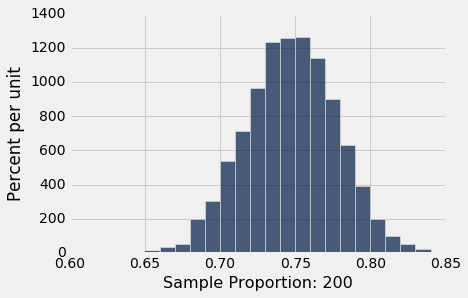

In [108]:
results.hist(bins=np.arange(0.65, 0.85, 0.01))

There's that normal curve again, as predicted by the Central Limit Theorem, centered at around 0.75 just as you would expect.

How would this distribution change if we increased the sample size? Let's run the code again with a sample size of 800, and collect the results of simulations in the same table in which we collected simulations based on a sample size of 200. We will keep the number of `repetitions` the same as before so that the two columns have the same length.

In [109]:
props2 = make_array()

num_plants = 800

for i in np.arange(repetitions):
    sample = model.sample(num_plants)
    new_prop = np.count_nonzero(sample.column('Color') == 'Purple')/num_plants
    props2 = np.append(props2, new_prop)
    
results = results.with_column('Sample Proportion: 800', props2)

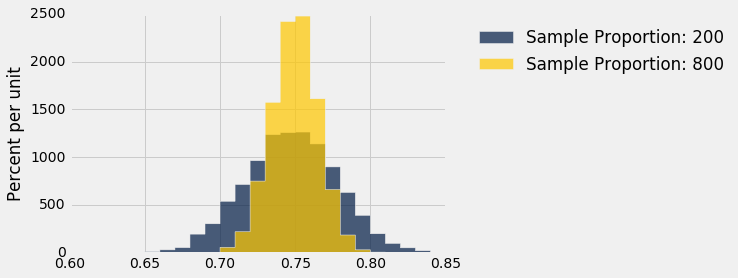

In [110]:
results.hist(bins=np.arange(0.65, 0.85, 0.01))

Both distributions are approximately normal but one is narrower than the other. The proportions based on a sample size of 800 are more tightly clustered around 0.75 than those from a sample size of 200. Increasing the sample size has decreased the variability in the sample proportion.

Exactly how does the sample size affect the variability of a sample average or proportion? That is the question we will examine in the next section.